***DATA 6610***

***Seth Stock***

***Final Project***

***April 25, 2025***

This is a revision of my first submission, where I have fixed the missing test set from the first code, and was able to slightly expand model parameters while waiting for it to run again.

In [ ]:

import os
import json
import pandas as pd
import numpy as np
import cv2
import torch
import torchvision.transforms as T
import matplotlib.pyplot as plt
from PIL import Image
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Paths 
image_dir = "/kaggle/input/textextraction/train_val_images/train_images"
json_path = "/kaggle/input/textextraction/TextOCR_0.1_train.json"
annot_csv = "/kaggle/input/textextraction/annot.csv"
img_csv = "/kaggle/input/textextraction/img.csv"

# Load data
with open(json_path, "r") as f:
    json_data = json.load(f)

annot_df = pd.read_csv(annot_csv)
img_df = pd.read_csv(img_csv)

# Merge CSVs and build image path
df = annot_df.merge(img_df[["id", "file_name", "width", "height"]], left_on="image_id", right_on="id")
df["file_path"] = df["file_name"].apply(lambda x: os.path.join(image_dir, os.path.basename(x)))
#Significantly downsample data to limit RAM usage
df = df.sample(n=1000, random_state=42).reset_index(drop=True)

In [ ]:
#SEGMENTATION - words into characters using cv2
def segment_letters(word_image, label_string):
    gray = cv2.cvtColor(word_image, cv2.COLOR_BGR2GRAY)
    _, thresh = cv2.threshold(gray, 127, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)

    # Find letter contours left-to-right
    contours, _ = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    bounding_boxes = sorted([cv2.boundingRect(c) for c in contours], key=lambda b: b[0])

    letter_images = []
    for (x, y, w, h) in bounding_boxes:
        letter_crop = word_image[y:y+h, x:x+w]
        resized = cv2.resize(letter_crop, (64,64))
        letter_images.append(resized / 255.0)

    return letter_images

from collections import Counter
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import numpy as np
#Automatically generate bounding boxes for characters from earlier segmentation
def parse_bbox(bbox_str):
    return [int(float(v)) for v in bbox_str.strip("[]").split(",")]

images = []
labels = []

for _, row in df.iterrows():
    try:
        bbox = [int(float(v)) for v in row["bbox"].strip("[]").split(",")]
        img = cv2.imread(row["file_path"])
        if img is None or not isinstance(row["utf8_string"], str):
            continue

        x, y, w, h = bbox
        word_crop = img[y:y+h, x:x+w]
        letter_imgs = segment_letters(word_crop, row["utf8_string"])

        if len(letter_imgs) != len(row["utf8_string"]):
            continue  # skip if segmentation fails

        for img, char in zip(letter_imgs, row["utf8_string"]):
            images.append(img)
            labels.append(char.upper())

    except Exception as e:
        continue

# AUGMENTATION - Make sure there's 200 examples of each character. 
freq = Counter(labels)
threshold = 200
#Define augmentation function
aug = ImageDataGenerator(
    rotation_range=15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    zoom_range=0.1,
    fill_mode='nearest'
)
#Actually do the thing loop
new_images, new_labels = [], []

for letter, count in freq.items():
    if count < threshold:
        needed = threshold - count
        letter_imgs = [img for img, lbl in zip(images, labels) if lbl == letter]
        if not letter_imgs:
            continue
        gen = aug.flow(np.stack(letter_imgs), np.zeros((len(letter_imgs),)), batch_size=1, shuffle=True)
        for _ in range(needed):
            aug_img, _ = next(gen)
            new_images.append(aug_img[0])
            new_labels.append(letter)

images.extend(new_images)
labels.extend(new_labels)
#Print number of unique characters and the minimum class count as a verification check
print(" Final character count:", len(labels))
print(" Post-augmentation min class count:", min(Counter(labels).values()))

2025-04-27 18:36:37.529383: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1745778997.725051      31 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1745778997.777284      31 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


 Final character count: 12400
 Post-augmentation min class count: 200


In [ ]:
# 3. LABEL ENCODING  - get everything ready for deep learning
from torch.utils.data import Dataset, DataLoader

# Encode characters
from sklearn.preprocessing import LabelEncoder

char_encoder = LabelEncoder()
char_labels_encoded = char_encoder.fit_transform(labels)
char_classes = list(char_encoder.classes_)

# Helper transform
import torchvision.transforms as T
from PIL import Image
import torch

img_transform = T.Compose([
    T.ToTensor()
])

# Dataset for characters
class LettersDataset(Dataset):
    def __init__(self, images, labels):
        self.images = images
        self.labels = labels

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        img = Image.fromarray((self.images[idx] * 255).astype(np.uint8))
        img = img.convert("RGB")
        tensor = img_transform(img)
        label = self.labels[idx]
        return tensor, label

# Train/val split for characters
from sklearn.model_selection import train_test_split

X_char_train, X_char_temp, y_char_train, y_char_temp = train_test_split(
    images, char_labels_encoded, test_size=0.2, stratify=char_labels_encoded, random_state=42
)

# Now split temp into val and test
X_char_val, X_char_test, y_char_val, y_char_test = train_test_split(
    X_char_temp, y_char_temp, test_size=0.5, stratify=y_char_temp, random_state=42
)

##Define dataloaders with batch sizes and stuff for later use. PyTorch moment.
train_char_dataset = LettersDataset(X_char_train, y_char_train)
val_char_dataset = LettersDataset(X_char_val, y_char_val)
test_char_dataset = LettersDataset(X_char_test, y_char_test)
train_char_loader = DataLoader(train_char_dataset, batch_size=32, shuffle=True)
val_char_loader = DataLoader(val_char_dataset, batch_size=32)
test_char_loader = DataLoader(test_char_dataset, batch_size=32, shuffle=False, num_workers=2)

print(" Character dataset ready for training")


 Character dataset ready for training


In [ ]:
# Extract word images and full strings from original segmentation logic
from sklearn.preprocessing import LabelEncoder

# Only rebuild word-level data if not already included
if 'word_images' not in globals():
    word_images = []
    word_labels = []
    texts = []

    for _, row in df.iterrows():
        try:
            bbox = [int(float(v)) for v in row["bbox"].strip("[]").split(",")]
            img = cv2.imread(row["file_path"])
            if img is None or not isinstance(row["utf8_string"], str):
                continue

            x, y, w, h = bbox
            word_crop = img[y:y+h, x:x+w]
            resized_word = cv2.resize(word_crop, (int(word_crop.shape[1] * (64 / word_crop.shape[0])), 64))
            word_images.append(resized_word / 255.0)
            word_labels.append(row["utf8_string"].upper())
            texts.append(row["utf8_string"].upper())
        except:
            continue

from collections import Counter
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Augment word-level data before encoding/labeling
word_freq = Counter(word_labels)
threshold = 100  

word_aug = ImageDataGenerator(
    rotation_range=10,
    width_shift_range=0.1,
    height_shift_range=0.05,
    zoom_range=0.1,
    shear_range=0.1,
    fill_mode='nearest'
)

aug_word_images = []
aug_word_labels = []
aug_texts = []

for label, count in word_freq.items():
    if count < threshold:
        needed = threshold - count
        samples = [(img, txt) for img, lbl, txt in zip(word_images, word_labels, texts) if lbl == label]
        if not samples:
            continue

        imgs = np.stack([cv2.resize(img, (176, 64)) for img, _ in samples])
        gen = word_aug.flow(imgs, np.zeros((len(imgs),)), batch_size=1, shuffle=True)

        for i in range(needed):
            aug_img, _ = next(gen)
            aug_word_images.append(aug_img[0])
            aug_word_labels.append(label)
            aug_texts.append(samples[i % len(samples)][1])  # replicate string

# Merge with originals
word_images.extend(aug_word_images)
word_labels.extend(aug_word_labels)
texts.extend(aug_texts)

print(" Word-level augmentation complete.")
print(f" Final word count: {len(word_labels)}")
print(f" Class min count: {min(Counter(word_labels).values())}")

# Encode word classes
word_encoder = LabelEncoder()
word_labels_encoded = word_encoder.fit_transform(word_labels)
word_classes = list(word_encoder.classes_)

# Create vocab with specials
special_tokens = ["<PAD>", "<SOS>", "<EOS>"]
char_vocab = special_tokens + char_classes
char_to_idx = {char: idx for idx, char in enumerate(char_vocab)}
pad_idx = char_to_idx["<PAD>"]
sos_idx = char_to_idx["<SOS>"]
eos_idx = char_to_idx["<EOS>"]

# Word dataset
class WordsDataset(Dataset):
    def __init__(self, images, word_labels, texts):
        self.images = images
        self.word_labels = word_labels
        self.texts = texts

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        img = Image.fromarray((self.images[idx] * 255).astype(np.uint8))
        img = img.convert("RGB")
        tensor = img_transform(img)
        word_label = self.word_labels[idx]
        seq = [char_to_idx["<SOS>"]] + [char_to_idx.get(c, pad_idx) for c in self.texts[idx]] + [char_to_idx["<EOS>"]]
        seq = torch.tensor(seq, dtype=torch.long)
        return tensor, word_label, seq

# Train/val split for word data
# First split into train and temp
X_word_train, X_word_temp, y_word_train, y_word_temp, seq_train, seq_temp = train_test_split(
    word_images, word_labels_encoded, texts, test_size=0.2, stratify=word_labels_encoded, random_state=42
)

# Now split temp into val and test
X_word_val, X_word_test, y_word_val, y_word_test, seq_val, seq_test = train_test_split(
    X_word_temp, y_word_temp, seq_temp, test_size=0.5, stratify=y_word_temp, random_state=42
)
##Word dataloaders!
train_word_dataset = WordsDataset(X_word_train, y_word_train, seq_train)
val_word_dataset = WordsDataset(X_word_val, y_word_val, seq_val)
test_word_dataset = WordsDataset(X_word_test, y_word_test, seq_test)
train_word_loader = DataLoader(train_word_dataset, batch_size=16, shuffle=True)
val_word_loader = DataLoader(val_word_dataset, batch_size=16)
test_word_loader = DataLoader(test_word_dataset, batch_size=16, shuffle=False)
print(" Word dataset ready for training")

 Word-level augmentation complete.
 Final word count: 54253
 Class min count: 100
 Word dataset ready for training


In [ ]:

# 4. MODEL DEFINITIONS - get them all out of the way here so I can press run all.

import torch.nn as nn
import torch.nn.functional as F
# CNN for character classification - 
# three hidden layers flatten with maxpooling, 
# before an adaptive average pool in the third layer, 
# while four layers use the flattened output to make classification predictions. 
def build_cnn_char_model(num_classes):
    return nn.Sequential(
        nn.Conv2d(3, 64, 3, padding=1), nn.ReLU(), nn.MaxPool2d(2),
        nn.Conv2d(64, 128, 3, padding=1), nn.ReLU(), nn.MaxPool2d(2),
        nn.Conv2d(128, 256, 3, padding=1), nn.ReLU(), nn.AdaptiveAvgPool2d(1),
        nn.Flatten(),
        nn.Linear(256, 256), nn.ReLU(), nn.Dropout(0.1),
        nn.Linear(256, 128), nn.ReLU(), nn.Dropout(0.1),
        nn.Linear(128, 64), nn.ReLU(), nn.Dropout(0.1),
        nn.Linear(64, num_classes)
    )

# Transformer block for use in ViT and Dual model - four multiattention heads with a simple sequential output model.
class TransformerBlock(nn.Module):
    def __init__(self, embed_dim, heads, ff_mult=8, dropout=0.1):
        super().__init__()
        self.norm1 = nn.LayerNorm(embed_dim)
        self.attn = nn.MultiheadAttention(embed_dim, heads, dropout=dropout, batch_first=True)
        self.norm2 = nn.LayerNorm(embed_dim)
        self.ff = nn.Sequential(
            nn.Linear(embed_dim, embed_dim * ff_mult),
            nn.ReLU(),
            nn.Linear(embed_dim * ff_mult, embed_dim)
        )
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        attn_out, _ = self.attn(self.norm1(x), self.norm1(x), self.norm1(x))
        x = x + self.dropout(attn_out)
        ff_out = self.ff(self.norm2(x))
        return x + self.dropout(ff_out)

# ViT for character classification - another silly test model. 
# Has number of classes defined and some pretty cool parameters. 
# Helped me figure out what worked and what didn't for the dual model while requiring substantially less compute time.

class ViTCharacterClassifier(nn.Module):
    def __init__(self, image_size=64, patch_size=4, num_classes=100, embed_dim=128, depth=4, heads=4):
        super().__init__()
        assert image_size % patch_size == 0
        self.num_patches = (image_size // patch_size) ** 2
        patch_dim = 3 * patch_size * patch_size
        self.patch_embed = nn.Conv2d(3, embed_dim, kernel_size=patch_size, stride=patch_size)
        self.cls_token = nn.Parameter(torch.randn(1, 1, embed_dim))
        self.pos_embed = nn.Parameter(torch.randn(1, self.num_patches + 1, embed_dim))
        self.blocks = nn.Sequential(*[TransformerBlock(embed_dim, heads) for _ in range(depth)])
        self.norm = nn.LayerNorm(embed_dim)
        self.head = nn.Linear(embed_dim, num_classes)

    def forward(self, x):
        B = x.size(0)
        x = self.patch_embed(x).flatten(2).transpose(1, 2)
        cls_tokens = self.cls_token.expand(B, -1, -1)
        x = torch.cat([cls_tokens, x], dim=1)
        x = x + self.pos_embed[:, :x.size(1)]
        x = self.blocks(x)
        x = self.norm(x[:, 0])
        return self.head(x)

# Dual-output model for word+char sequence 
# This is where the action is. Thousands of word classes, more depth of blocks than attention heads
# Embedded convoluational layers engage with the transformer encoding block defined earlier
# CLS tokens and embeddings transferred to decoder
class DualOutputTransformer(nn.Module):
    def __init__(self, char_vocab_size, word_classes, embed_dim=512, heads=16, depth=8, dropout=0.1):
        super().__init__()
        self.embed_dim = embed_dim
        self.patch_embed = nn.Conv2d(3, embed_dim, kernel_size=6, stride=6)
        self.num_patches = (64 // 6) * (176 // 6)
        self.pos_embed = nn.Parameter(torch.randn(1, self.num_patches + 1, embed_dim))
        self.cls_token = nn.Parameter(torch.randn(1, 1, embed_dim))

        self.encoder = nn.Sequential(*[
            TransformerBlock(embed_dim, heads, dropout=dropout) for _ in range(depth)
        ])
        self.enc_norm = nn.LayerNorm(embed_dim)
        self.word_head = nn.Linear(embed_dim, word_classes)

        self.char_emb = nn.Embedding(char_vocab_size, embed_dim)
        self.char_pos = nn.Parameter(torch.randn(1, 64, embed_dim))
        decoder_layer = nn.TransformerDecoderLayer(
            d_model=embed_dim, nhead=heads, dim_feedforward=embed_dim*4,
            dropout=dropout, batch_first=True
        )
        self.decoder = nn.TransformerDecoder(decoder_layer, num_layers=depth)
        self.char_out = nn.Linear(embed_dim, char_vocab_size)
##This bit defines the character sequence prediction logic
#Takes the last output to predict the most likely next letter in the sequence from the image.

    def forward(self, x, tgt_seq):
        B = x.size(0)
        x = self.patch_embed(x).flatten(2).transpose(1, 2)
        cls_token = self.cls_token.expand(B, -1, -1)
        x = torch.cat([cls_token, x], dim=1)
        x = x + self.pos_embed[:, :x.size(1)]
        x = self.encoder(x)
        memory = self.enc_norm(x)

        word_logits = self.word_head(memory[:, 0])

        tgt_emb = self.char_emb(tgt_seq) + self.char_pos[:, :tgt_seq.size(1)]
        tgt_mask = nn.Transformer.generate_square_subsequent_mask(tgt_seq.size(1)).to(tgt_seq.device)
        decoded = self.decoder(tgt=tgt_emb, memory=memory, tgt_mask=tgt_mask)
        char_logits = self.char_out(decoded)

        return word_logits, char_logits


In [ ]:


# Initialize models and send to GPU
char_model = build_cnn_char_model(num_classes=len(char_classes))
vitchar_model = ViTCharacterClassifier(num_classes=len(char_classes))
dual_model = DualOutputTransformer(char_vocab_size=len(char_to_idx), word_classes=len(word_classes))


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


In [ ]:
# Configure training
BATCH_SIZE = 32
EPOCHS = 25

# Chance to update dataloader batch sizes because sometimes I forget
train_char_loader = DataLoader(train_char_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_char_loader = DataLoader(val_char_dataset, batch_size=BATCH_SIZE)


In [ ]:
##Convolutional character model training function - PyTorch moment
from torch.optim import Adam
from torch.nn import CrossEntropyLoss



def fit_char_model(model, train_loader, val_loader, num_epochs, device):
    optimizer = Adam(model.parameters(), lr=1e-3)
    criterion = CrossEntropyLoss()
    model.to(device)
    history = {'loss': [], 'val_loss': [], 'acc': [], 'val_acc': []}

    for epoch in range(num_epochs):
        model.train()
        total_loss, correct, total = 0, 0, 0
        for x, y in train_loader:
            x, y = x.to(device), y.to(device)
            optimizer.zero_grad()
            logits = model(x)
            loss = criterion(logits, y)
            loss.backward()
            optimizer.step()
            total_loss += loss.item() * y.size(0)
            correct += (logits.argmax(1) == y).sum().item()
            total += y.size(0)

        model.eval()
        val_loss, val_correct, val_total = 0, 0, 0
        with torch.no_grad():
            for x, y in val_loader:
                x, y = x.to(device), y.to(device)
                logits = model(x)
                loss = criterion(logits, y)
                val_loss += loss.item() * y.size(0)
                val_correct += (logits.argmax(1) == y).sum().item()
                val_total += y.size(0)

        history['loss'].append(total_loss / total)
        history['val_loss'].append(val_loss / val_total)
        history['acc'].append(correct / total)
        history['val_acc'].append(val_correct / val_total)

        print(f"[Epoch {epoch+1}] Loss: {total_loss/total:.4f} | Acc: {correct/total:.4f} | Val Loss: {val_loss/val_total:.4f} | Val Acc: {val_correct/val_total:.4f}")

    return history
    # Training steps are based on validation loss. The way it should be. 
# Cross Entropy loss metric is used for classification purposes.



In [ ]:
print(char_model)
#Prints out the model because PyTorch doesnt have that awesome summary function

Sequential(
  (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): ReLU()
  (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (4): ReLU()
  (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (6): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (7): ReLU()
  (8): AdaptiveAvgPool2d(output_size=1)
  (9): Flatten(start_dim=1, end_dim=-1)
  (10): Linear(in_features=256, out_features=256, bias=True)
  (11): ReLU()
  (12): Dropout(p=0.1, inplace=False)
  (13): Linear(in_features=256, out_features=128, bias=True)
  (14): ReLU()
  (15): Dropout(p=0.1, inplace=False)
  (16): Linear(in_features=128, out_features=64, bias=True)
  (17): ReLU()
  (18): Dropout(p=0.1, inplace=False)
  (19): Linear(in_features=64, out_features=62, bias=True)
)


In [ ]:
# Train chararacter level CNN and put all the stuff into an object for plotting and validation steps

history_char = fit_char_model(char_model, train_char_loader, val_char_loader, num_epochs=EPOCHS, device=device)


[Epoch 1] Loss: 3.8183 | Acc: 0.0446 | Val Loss: 3.4809 | Val Acc: 0.0750
[Epoch 2] Loss: 3.2979 | Acc: 0.1264 | Val Loss: 2.8092 | Val Acc: 0.2629
[Epoch 3] Loss: 2.6594 | Acc: 0.2734 | Val Loss: 2.1754 | Val Acc: 0.3960
[Epoch 4] Loss: 2.1716 | Acc: 0.4057 | Val Loss: 1.7421 | Val Acc: 0.5476
[Epoch 5] Loss: 1.7869 | Acc: 0.5091 | Val Loss: 1.5038 | Val Acc: 0.5839
[Epoch 6] Loss: 1.5941 | Acc: 0.5527 | Val Loss: 1.2897 | Val Acc: 0.6290
[Epoch 7] Loss: 1.4290 | Acc: 0.5895 | Val Loss: 1.1441 | Val Acc: 0.6685
[Epoch 8] Loss: 1.3010 | Acc: 0.6175 | Val Loss: 1.0609 | Val Acc: 0.6790
[Epoch 9] Loss: 1.1931 | Acc: 0.6471 | Val Loss: 1.0282 | Val Acc: 0.6806
[Epoch 10] Loss: 1.1291 | Acc: 0.6637 | Val Loss: 0.9089 | Val Acc: 0.7363
[Epoch 11] Loss: 1.0454 | Acc: 0.6830 | Val Loss: 0.9048 | Val Acc: 0.7202
[Epoch 12] Loss: 1.0006 | Acc: 0.6985 | Val Loss: 0.8036 | Val Acc: 0.7565
[Epoch 13] Loss: 0.9959 | Acc: 0.6954 | Val Loss: 0.8167 | Val Acc: 0.7597
[Epoch 14] Loss: 0.9164 | Acc: 0.7

The convolutional model ended up fitting quite well, surprisingly. It is very lightweight, which is a good sign for our convolutional autencoder in the dual model

In [ ]:
#Probably redundant imports because I run these files in wild orders or otherwise forget. 

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, accuracy_score
import matplotlib.pyplot as plt
import numpy as np
import torch
import random

In [ ]:
##Switch the model into evaluation mode and calculate prediction accuracy.

char_model.eval()
all_preds = []
all_labels = []
all_images = []

with torch.no_grad():
    for images, labels in test_char_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = char_model(images)
        _, preds = torch.max(outputs, 1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())
        all_images.extend(images.cpu().numpy())

print(f" Character Validation Accuracy: {accuracy_score(all_labels, all_preds):.4f}")

 Character Validation Accuracy: 0.8403


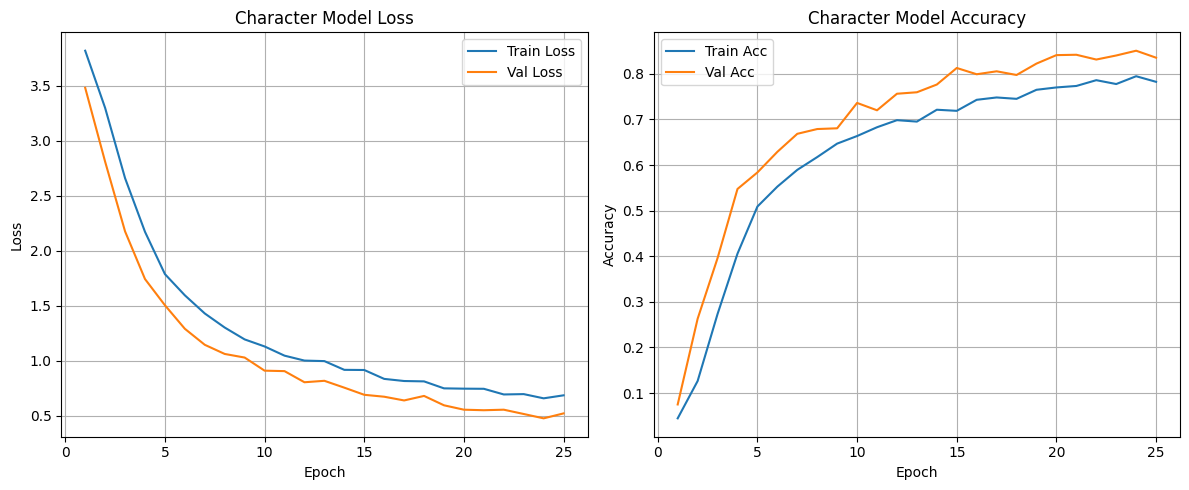

In [ ]:
#Model loss and accuracy between train and val sets over epochs
epochs = range(1, len(history_char['loss']) + 1)

plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(epochs, history_char['loss'], label='Train Loss')
plt.plot(epochs, history_char['val_loss'], label='Val Loss')
plt.title("Character Model Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(epochs, history_char['acc'], label='Train Acc')
plt.plot(epochs, history_char['val_acc'], label='Val Acc')
plt.title("Character Model Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()


Model loss and accuracy between validation and training sets indicates that the model is fitting well and that we have reached somewhat of a local minima for this model, data, batch size, and epochs.

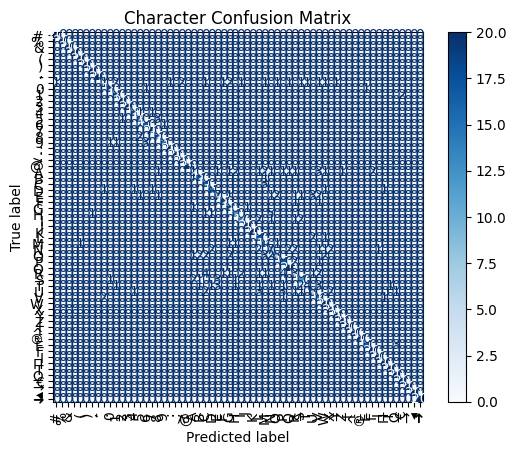

In [ ]:
##Confusion matrix is pretty much useless but gives me at least some idea of the prediction distribution

cm = confusion_matrix(all_labels, all_preds)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=char_classes)
disp.plot(cmap='Blues', xticks_rotation='vertical')
plt.title('Character Confusion Matrix')
plt.show()


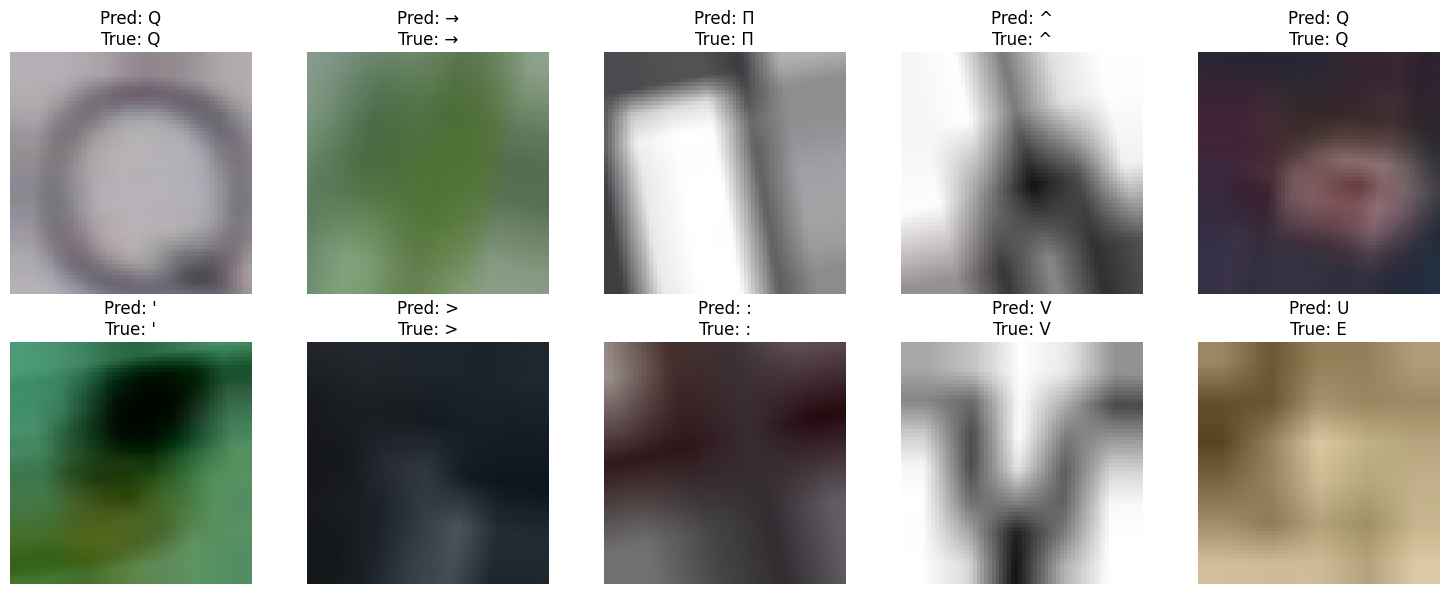

In [15]:
plt.figure(figsize=(15, 6))
sample_indices = random.sample(range(len(all_images)), 10)

for i, idx in enumerate(sample_indices):
    plt.subplot(2, 5, i+1)
    img = all_images[idx].squeeze()
    if img.ndim == 3:
        img = np.transpose(img, (1, 2, 0))
    plt.imshow(img, cmap='gray')
    plt.title(f"Pred: {char_classes[all_preds[idx]]}\nTrue: {char_classes[all_labels[idx]]}")
    plt.axis('off')

plt.tight_layout()
plt.show()


Provides some insight as to what the model might be mispredicting. U and E is pretty interesting. 

In [ ]:

from torch.optim import Adam
from torch.nn import CrossEntropyLoss

# Train vision transformer to predict characters

def fit_vitchar_model(model, train_loader, val_loader, num_epochs, device):
    optimizer = Adam(model.parameters(), lr=1e-3)
    criterion = CrossEntropyLoss()
    model.to(device)
    history = {'loss': [], 'val_loss': [], 'acc': [], 'val_acc': []}

    for epoch in range(num_epochs):
        model.train()
        total_loss, correct, total = 0, 0, 0
        for x, y in train_loader:
            x, y = x.to(device), y.to(device)
            optimizer.zero_grad()
            logits = model(x)
            loss = criterion(logits, y)
            loss.backward()
            optimizer.step()
            total_loss += loss.item() * y.size(0)
            correct += (logits.argmax(1) == y).sum().item()
            total += y.size(0)

        model.eval()
        val_loss, val_correct, val_total = 0, 0, 0
        with torch.no_grad():
            for x, y in val_loader:
                x, y = x.to(device), y.to(device)
                logits = model(x)
                loss = criterion(logits, y)
                val_loss += loss.item() * y.size(0)
                val_correct += (logits.argmax(1) == y).sum().item()
                val_total += y.size(0)

        history['loss'].append(total_loss / total)
        history['val_loss'].append(val_loss / val_total)
        history['acc'].append(correct / total)
        history['val_acc'].append(val_correct / val_total)

        print(f"[Epoch {epoch+1}] Loss: {total_loss/total:.4f} | Acc: {correct/total:.4f} | Val Loss: {val_loss/val_total:.4f} | Val Acc: {val_correct/val_total:.4f}")

    return history


In [17]:
print(vitchar_model)

ViTCharacterClassifier(
  (patch_embed): Conv2d(3, 128, kernel_size=(4, 4), stride=(4, 4))
  (blocks): Sequential(
    (0): TransformerBlock(
      (norm1): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
      (attn): MultiheadAttention(
        (out_proj): NonDynamicallyQuantizableLinear(in_features=128, out_features=128, bias=True)
      )
      (norm2): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
      (ff): Sequential(
        (0): Linear(in_features=128, out_features=1024, bias=True)
        (1): ReLU()
        (2): Linear(in_features=1024, out_features=128, bias=True)
      )
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (1): TransformerBlock(
      (norm1): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
      (attn): MultiheadAttention(
        (out_proj): NonDynamicallyQuantizableLinear(in_features=128, out_features=128, bias=True)
      )
      (norm2): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
      (ff): Sequential(
        (0):

In [ ]:
# Train character-level model 
history_vitchar = fit_vitchar_model(vitchar_model, train_char_loader, val_char_loader, num_epochs=EPOCHS, device=device)


[Epoch 1] Loss: 3.3497 | Acc: 0.1929 | Val Loss: 2.0877 | Val Acc: 0.4976
[Epoch 2] Loss: 1.6558 | Acc: 0.5761 | Val Loss: 1.2153 | Val Acc: 0.6774
[Epoch 3] Loss: 1.1049 | Acc: 0.6921 | Val Loss: 0.8640 | Val Acc: 0.7573
[Epoch 4] Loss: 0.8160 | Acc: 0.7672 | Val Loss: 0.6464 | Val Acc: 0.8185
[Epoch 5] Loss: 0.6363 | Acc: 0.8128 | Val Loss: 0.4730 | Val Acc: 0.8637
[Epoch 6] Loss: 0.5345 | Acc: 0.8390 | Val Loss: 0.4584 | Val Acc: 0.8637
[Epoch 7] Loss: 0.4517 | Acc: 0.8609 | Val Loss: 0.3181 | Val Acc: 0.9024
[Epoch 8] Loss: 0.3641 | Acc: 0.8894 | Val Loss: 0.3661 | Val Acc: 0.8952
[Epoch 9] Loss: 0.3102 | Acc: 0.9025 | Val Loss: 0.3026 | Val Acc: 0.9202
[Epoch 10] Loss: 0.3149 | Acc: 0.9018 | Val Loss: 0.2959 | Val Acc: 0.9105
[Epoch 11] Loss: 0.2494 | Acc: 0.9246 | Val Loss: 0.2493 | Val Acc: 0.9242
[Epoch 12] Loss: 0.2652 | Acc: 0.9153 | Val Loss: 0.2418 | Val Acc: 0.9298
[Epoch 13] Loss: 0.2220 | Acc: 0.9293 | Val Loss: 0.3294 | Val Acc: 0.9089
[Epoch 14] Loss: 0.2169 | Acc: 0.9

The character-level vision tranformer acheieved over 95% accuracy on the validation set, which is fantastic. With more capacity it will be able to classify characters nearly perfectly.

In [19]:
vitchar_model.eval()
all_preds = []
all_labels = []
all_images = []

with torch.no_grad():
    for images, labels in test_char_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = vitchar_model(images)
        _, preds = torch.max(outputs, 1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())
        all_images.extend(images.cpu().numpy())

from sklearn.metrics import accuracy_score
print(f" ViTChar Validation Accuracy: {accuracy_score(all_labels, all_preds):.4f}")


 ViTChar Validation Accuracy: 0.9661


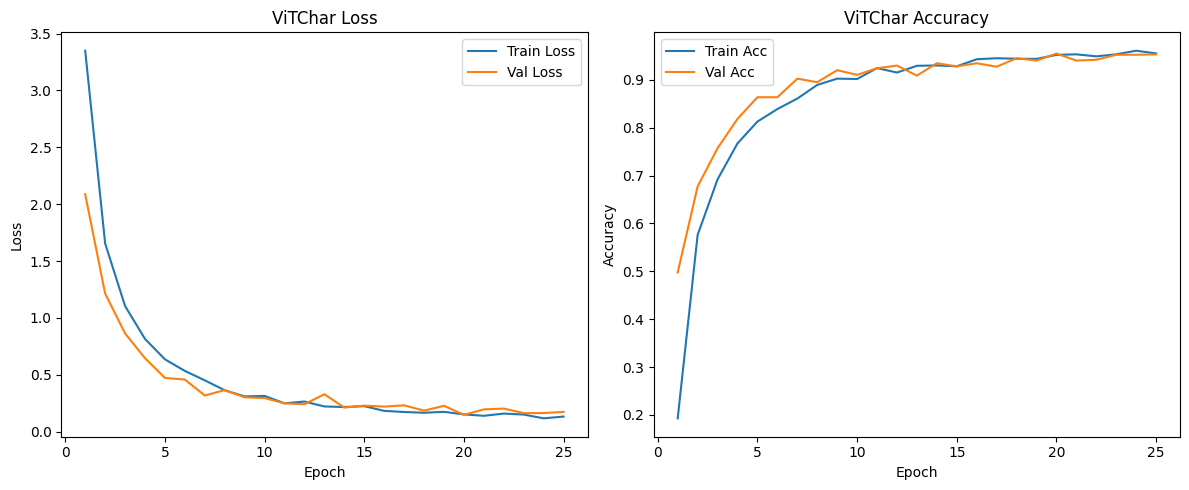

In [20]:
epochs = range(1, len(history_vitchar['loss']) + 1)

plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(epochs, history_vitchar['loss'], label='Train Loss')
plt.plot(epochs, history_vitchar['val_loss'], label='Val Loss')
plt.title("ViTChar Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(epochs, history_vitchar['acc'], label='Train Acc')
plt.plot(epochs, history_vitchar['val_acc'], label='Val Acc')
plt.title("ViTChar Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()

plt.tight_layout()
plt.show()


The model training vs validation loss and accuracy across epochs indicates that the ViTChar model is fitting very well, better than the CNN. This validates the vision transformer as the optimal option for varied character detection in images.

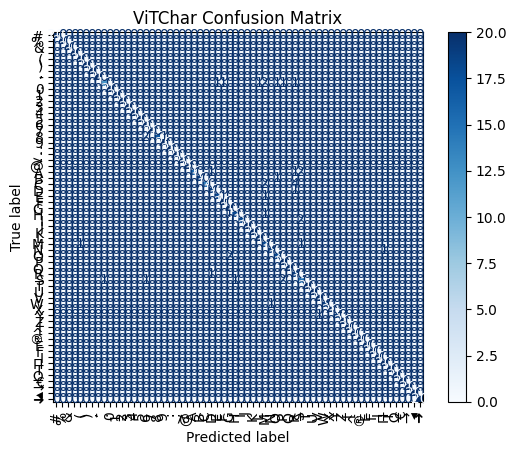

In [21]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

cm = confusion_matrix(all_labels, all_preds)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=char_classes)
disp.plot(cmap='Blues', xticks_rotation='vertical')
plt.title('ViTChar Confusion Matrix')
plt.show()


In [22]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

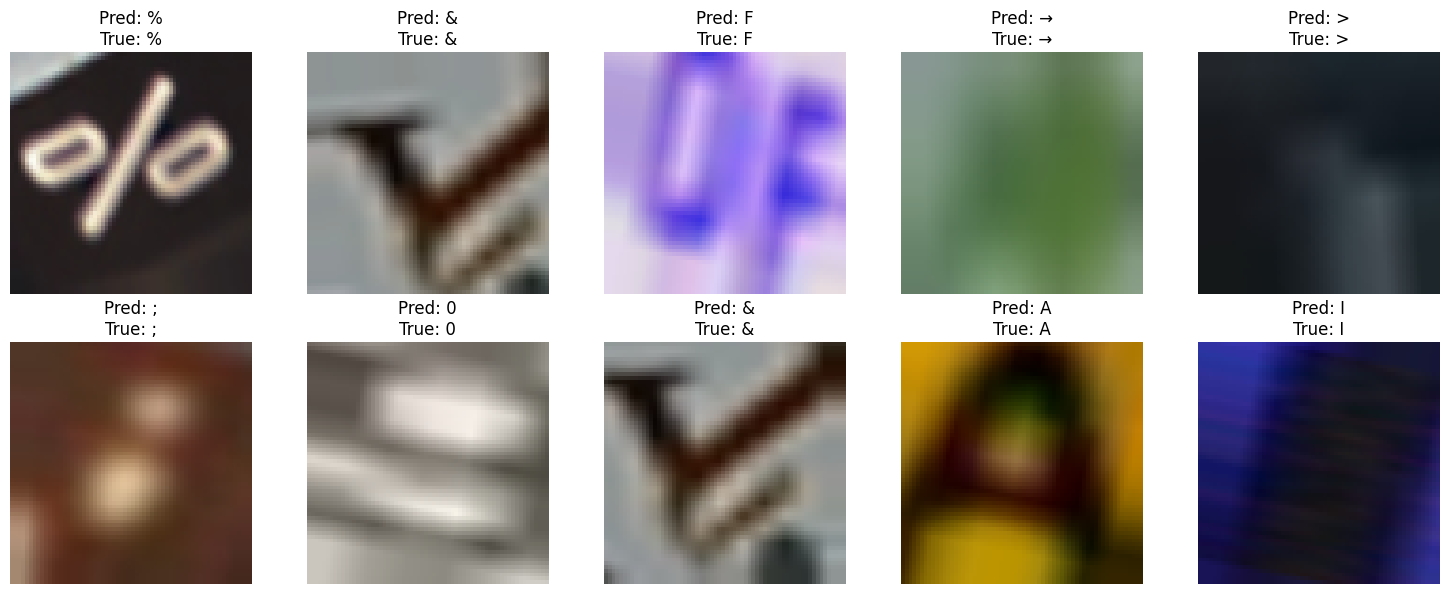

In [23]:
import random

plt.figure(figsize=(15, 6))
sample_indices = random.sample(range(len(all_images)), 10)

for i, idx in enumerate(sample_indices):
    plt.subplot(2, 5, i + 1)
    img = all_images[idx].squeeze()
    if img.ndim == 3:
        img = np.transpose(img, (1, 2, 0))
    plt.imshow(img, cmap='gray')
    plt.title(f"Pred: {char_classes[all_preds[idx]]}\nTrue: {char_classes[all_labels[idx]]}")
    plt.axis('off')

plt.tight_layout()
plt.show()


From the small qualitative sample, it is already clear that the vision transformer performs better than the CNN for character classification. I can't even tell you what most of these characters are supposed to be. 

In [ ]:
# Initialize dual output model. 
# 8 transformer blocks to help capture general trends
# 32 embedding dimensions per attention head seems to be in the sweet spot
dual_model = DualOutputTransformer(
    char_vocab_size=len(char_to_idx),
    word_classes=len(word_classes),
    embed_dim=512,
    heads=16,
    depth=8
)

In [ ]:
##Define fitting function. Another pytorch moment
def fit_dual_model(
    model,
    train_loader,
    val_loader,
    num_epochs,
    pad_idx,
    device,
    lr=1e-4,
    alpha=3.0,       # Word loss weight
    beta=.5,        # Char loss weight
    grad_clip=1.0,
    scheduler_patience=2,
    scheduler_factor=0.5
):#utilize AdamW optimizer to take advantage of weight decay while using crossentropy loss as the loss metric.
    optimizer = torch.optim.AdamW(model.parameters(), lr=lr, weight_decay = 1e-2)
    word_loss_fn = nn.CrossEntropyLoss(label_smoothing=0.1)  # smoother word class prediction
    char_loss_fn = nn.CrossEntropyLoss(ignore_index=pad_idx)

    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', patience=scheduler_patience, factor=scheduler_factor)

    model.to(device)
    history = {'train_loss': [], 'val_loss': [], 'word_loss': [], 'char_loss': []}

    for epoch in range(num_epochs):
        model.train()
        total_loss, total_word, total_char = 0, 0, 0

        for x, y_word, y_seq in train_loader:
            x, y_word, y_seq = x.to(device), y_word.to(device), y_seq.to(device)
            optimizer.zero_grad()

            word_logits, char_logits = model(x, y_seq[:, :-1])  # exclude <EOS> for input
            word_loss = word_loss_fn(word_logits, y_word)
            char_loss = char_loss_fn(
                char_logits.reshape(-1, char_logits.size(-1)),
                y_seq[:, 1:].reshape(-1)  # shift left for target
            )

            loss = alpha * word_loss + beta * char_loss
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), grad_clip)
            optimizer.step()

            total_loss += loss.item() * x.size(0)
            total_word += word_loss.item() * x.size(0)
            total_char += char_loss.item() * x.size(0)

        avg_train_loss = total_loss / len(train_loader.dataset)
        avg_train_word = total_word / len(train_loader.dataset)
        avg_train_char = total_char / len(train_loader.dataset)

        # validation loop for each training step.
        model.eval()
        val_loss, val_word, val_char = 0, 0, 0

        with torch.no_grad():
            for x, y_word, y_seq in val_loader:
                x, y_word, y_seq = x.to(device), y_word.to(device), y_seq.to(device)
                word_logits, char_logits = model(x, y_seq[:, :-1])
                word_loss = word_loss_fn(word_logits, y_word)
                char_loss = char_loss_fn(
                    char_logits.reshape(-1, char_logits.size(-1)),
                    y_seq[:, 1:].reshape(-1)
                )
                loss = alpha * word_loss + beta * char_loss

                val_loss += loss.item() * x.size(0)
                val_word += word_loss.item() * x.size(0)
                val_char += char_loss.item() * x.size(0)

        avg_val_loss = val_loss / len(val_loader.dataset)
        avg_val_word = val_word / len(val_loader.dataset)
        avg_val_char = val_char / len(val_loader.dataset)

        scheduler.step(avg_val_loss)

        # Save to history
        history['train_loss'].append(avg_train_loss)
        history['val_loss'].append(avg_val_loss)
        history['word_loss'].append(avg_train_word)
        history['char_loss'].append(avg_train_char)

        print(f"[Epoch {epoch+1}]  Train: {avg_train_loss:.4f} | Val: {avg_val_loss:.4f} | Word: {avg_val_word:.4f} | Char: {avg_val_char:.4f}")

    return history


In [ ]:
##make sure words data is all good to go for the transformer.

import torchvision.transforms as T
from torch.nn.utils.rnn import pad_sequence

fixed_width = 176  # updated to ensure 121 patches (11x11) for ViT compatibility
fixed_height = 64
resize_transform = T.Resize((fixed_height, fixed_width))

class FixedWidthWordsDataset(Dataset):
    def __init__(self, images, word_labels, texts):
        self.images = images
        self.word_labels = word_labels
        self.texts = texts

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        img = Image.fromarray((self.images[idx] * 255).astype(np.uint8)).convert("RGB")
        img = resize_transform(img)
        tensor = T.ToTensor()(img)
        word_label = self.word_labels[idx]
        seq = [char_to_idx["<SOS>"]] + [char_to_idx.get(c, pad_idx) for c in self.texts[idx]] + [char_to_idx["<EOS>"]]
        seq = torch.tensor(seq, dtype=torch.long)
        return tensor, int(word_label), seq

def collate_dual(batch):
    imgs, word_labels, seqs = zip(*batch)
    imgs = torch.stack(imgs)
    word_labels = torch.tensor(word_labels, dtype=torch.long)
    seqs_padded = pad_sequence(seqs, batch_first=True, padding_value=pad_idx)
    return imgs, word_labels, seqs_padded

train_word_dataset = FixedWidthWordsDataset(X_word_train, y_word_train, seq_train)
val_word_dataset = FixedWidthWordsDataset(X_word_val, y_word_val, seq_val)
test_word_dataset = FixedWidthWordsDataset(X_word_test, y_word_test, seq_test)
##Bake in batch size for the dataloaders. Pytorch moment
train_word_loader = DataLoader(train_word_dataset, batch_size=32, shuffle=True, collate_fn=collate_dual)
val_word_loader = DataLoader(val_word_dataset, batch_size=32, collate_fn=collate_dual)
test_word_loader = DataLoader(test_word_dataset, batch_size=32, collate_fn = collate_dual)
print("Word image sizes padded & resized to match ViT position embeddings")

Word image sizes padded & resized to match ViT position embeddings


In [27]:
# Configure and train


history_dual = fit_dual_model(
    dual_model,
    train_loader=train_word_loader,
    val_loader=val_word_loader,
    num_epochs=25,
    pad_idx=pad_idx,
    device=device,
    lr=1e-4,
    alpha=3.0,
    beta=.5
)

[Epoch 1]  Train: 14.0616 | Val: 6.6285 | Word: 2.1247 | Char: 0.5086
[Epoch 2]  Train: 4.8698 | Val: 3.7627 | Word: 1.2363 | Char: 0.1074
[Epoch 3]  Train: 3.6957 | Val: 3.7291 | Word: 1.2250 | Char: 0.1080
[Epoch 4]  Train: 3.4601 | Val: 3.3801 | Word: 1.1170 | Char: 0.0581
[Epoch 5]  Train: 3.3196 | Val: 3.3543 | Word: 1.1098 | Char: 0.0500
[Epoch 6]  Train: 3.2299 | Val: 3.2828 | Word: 1.0872 | Char: 0.0427
[Epoch 7]  Train: 3.1571 | Val: 3.2028 | Word: 1.0640 | Char: 0.0215
[Epoch 8]  Train: 3.1016 | Val: 3.1489 | Word: 1.0455 | Char: 0.0246
[Epoch 9]  Train: 3.0676 | Val: 3.0945 | Word: 1.0286 | Char: 0.0172
[Epoch 10]  Train: 3.0369 | Val: 3.1003 | Word: 1.0295 | Char: 0.0238
[Epoch 11]  Train: 3.0085 | Val: 3.0798 | Word: 1.0240 | Char: 0.0159
[Epoch 12]  Train: 2.9870 | Val: 3.0702 | Word: 1.0214 | Char: 0.0121
[Epoch 13]  Train: 2.9746 | Val: 3.0950 | Word: 1.0284 | Char: 0.0193
[Epoch 14]  Train: 2.9669 | Val: 3.0943 | Word: 1.0265 | Char: 0.0299
[Epoch 15]  Train: 2.9538 | 

In [28]:
dual_model.eval()
word_preds = []
word_true = []
word_images = []

with torch.no_grad():
    for x, y_word, y_seq in test_word_loader:
        x, y_word = x.to(device), y_word.to(device)
        logits, _ = dual_model(x, y_seq.to(device))
        _, preds = torch.max(logits, 1)
        word_preds.extend(preds.cpu().numpy())
        word_true.extend(y_word.cpu().numpy())
        word_images.extend(x.cpu().numpy())

print(f"Dual Model Word Accuracy: {accuracy_score(word_true, word_preds):.4f}")


Dual Model Word Accuracy: 0.9923


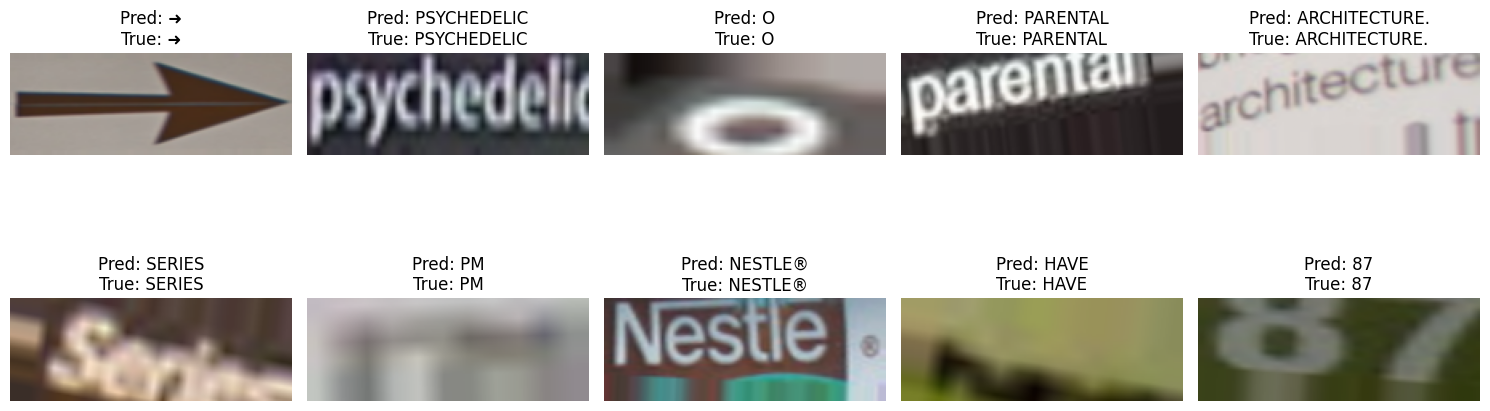

In [29]:
plt.figure(figsize=(15, 6))
sample_indices = random.sample(range(len(word_images)), 10)

for i, idx in enumerate(sample_indices):
    plt.subplot(2, 5, i + 1)
    img = word_images[idx].squeeze()
    if img.ndim == 3:
        img = np.transpose(img, (1, 2, 0))
    plt.imshow(img, cmap='gray')
    plt.title(f"Pred: {word_classes[word_preds[idx]]}\nTrue: {word_classes[word_true[idx]]}")
    plt.axis('off')

plt.tight_layout()
plt.show()


In [30]:
char_preds = []
char_truth = []
char_images = []

dual_model.eval()

with torch.no_grad():
    for x, y_word, y_seq in test_word_loader:
        x, y_seq = x.to(device), y_seq.to(device)
        _, char_logits = dual_model(x, y_seq)

        pred_seq = torch.argmax(char_logits, dim=-1)  # Shape: [batch_size, seq_len]

        for i in range(pred_seq.size(0)):
            pred_tokens = pred_seq[i].cpu().tolist()
            true_tokens = y_seq[i, 1:].cpu().tolist()  # Skip SOS token

            pred_str = "".join([char_vocab[idx] for idx in pred_tokens if char_vocab[idx] not in ["<PAD>", "<EOS>"]])
            true_str = "".join([char_vocab[idx] for idx in true_tokens if char_vocab[idx] not in ["<PAD>", "<EOS>"]])

            char_preds.append(pred_str)
            char_truth.append(true_str)
            char_images.append(x[i].cpu().numpy())


In [31]:
exact_matches = sum(p == t for p, t in zip(char_preds, char_truth))
char_seq_accuracy = exact_matches / len(char_preds)
print(f" Exact sequence match accuracy: {char_seq_accuracy:.4f}")


 Exact sequence match accuracy: 0.1979


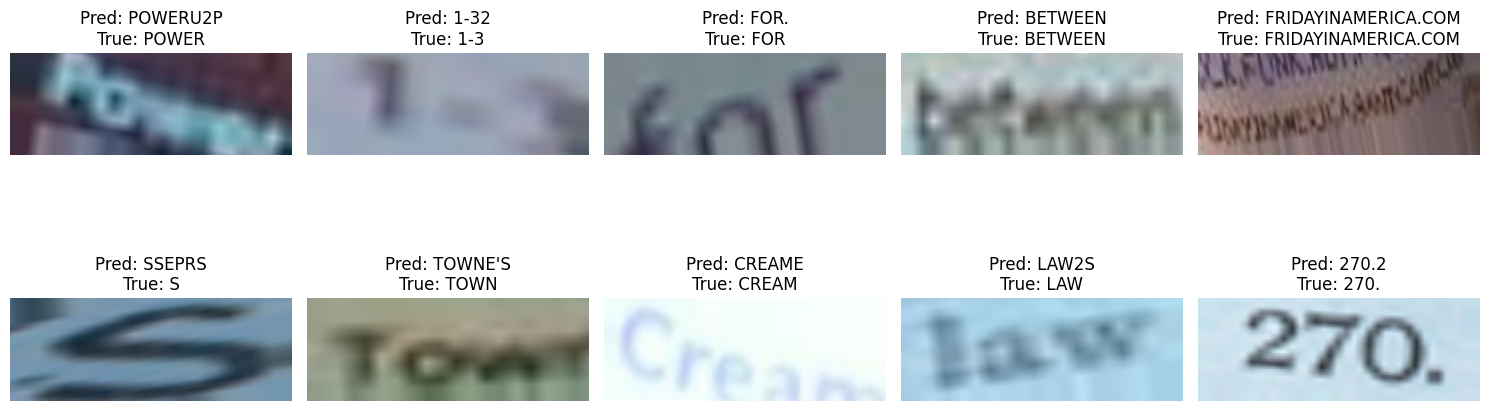

In [32]:
import matplotlib.pyplot as plt
import random

plt.figure(figsize=(15, 6))
sample_indices = random.sample(range(len(char_images)), 10)

for i, idx in enumerate(sample_indices):
    plt.subplot(2, 5, i + 1)
    img = char_images[idx].squeeze()
    if img.ndim == 3:
        img = np.transpose(img, (1, 2, 0))
    plt.imshow(img, cmap='gray')
    plt.title(f"Pred: {char_preds[idx]}\nTrue: {char_truth[idx]}")
    plt.axis('off')

plt.tight_layout()
plt.show()


In [33]:
!pip install python-Levenshtein

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 161.7/161.7 kB 4.1 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.1/3.1 MB 43.5 MB/s eta 0:00:0000:0100:01


In [34]:
import Levenshtein

# Calculate average Levenshtein distance and similarity
total_distance = 0
total_similarity = 0

for pred, truth in zip(char_preds, char_truth):
    dist = Levenshtein.distance(pred, truth)
    sim = Levenshtein.ratio(pred, truth)  # 0 to 1
    total_distance += dist
    total_similarity += sim

avg_distance = total_distance / len(char_preds)
avg_similarity = total_similarity / len(char_preds)

print(f" Avg. Levenshtein Distance: {avg_distance:.2f}")
print(f" Avg. Levenshtein Similarity: {avg_similarity:.2%}")


 Avg. Levenshtein Distance: 1.80
 Avg. Levenshtein Similarity: 80.48%


In [35]:


distances = []
similarities = []

for pred, truth in zip(char_preds, char_truth):
    distances.append(Levenshtein.distance(pred, truth))
    similarities.append(Levenshtein.ratio(pred, truth))  # 0 to 1


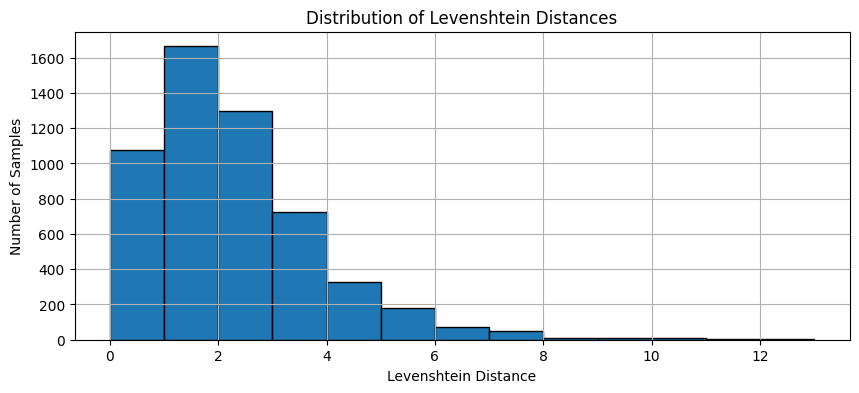

In [36]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 4))
plt.hist(distances, bins=range(0, max(distances)+2), edgecolor='black')
plt.title("Distribution of Levenshtein Distances")
plt.xlabel("Levenshtein Distance")
plt.ylabel("Number of Samples")
plt.grid(True)
plt.show()


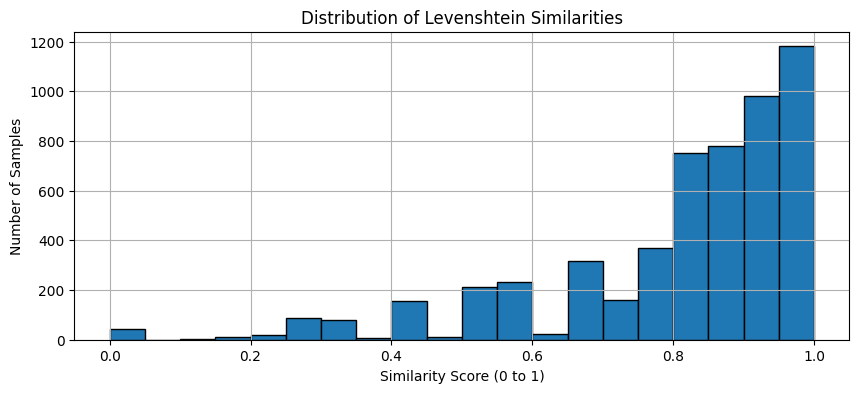

In [37]:
plt.figure(figsize=(10, 4))
plt.hist(similarities, bins=20, range=(0,1), edgecolor='black')
plt.title("Distribution of Levenshtein Similarities")
plt.xlabel("Similarity Score (0 to 1)")
plt.ylabel("Number of Samples")
plt.grid(True)
plt.show()


In [38]:
# Convert to tuples for easy sorting
scored_samples = list(zip(similarities, char_preds, char_truth))

# Sort by similarity
scored_samples.sort(key=lambda x: x[0], reverse=True)

print(" Best 10 Predictions:")
for sim, pred, truth in scored_samples[:10]:
    print(f"✓ {pred} | True: {truth} | Similarity: {sim:.2f}")

print("\n Worst 10 Predictions:")
for sim, pred, truth in scored_samples[-10:]:
    print(f"✗ {pred} | True: {truth} | Similarity: {sim:.2f}")


 Best 10 Predictions:
✓ DIAL. | True: DIAL. | Similarity: 1.00
✓ SLINTO | True: SLINTO | Similarity: 1.00
✓ BROUWERIJ- | True: BROUWERIJ- | Similarity: 1.00
✓ PROCESS. | True: PROCESS. | Similarity: 1.00
✓ EFECTOS | True: EFECTOS | Similarity: 1.00
✓ MOVEMENT: | True: MOVEMENT: | Similarity: 1.00
✓ OBLITTCRAT: | True: OBLITTCRAT: | Similarity: 1.00
✓ MOVEMENTS | True: MOVEMENTS | Similarity: 1.00
✓ OVERDRIVE, | True: OVERDRIVE, | Similarity: 1.00
✓ MAVERICKS | True: MAVERICKS | Similarity: 1.00

 Worst 10 Predictions:
✗ BPR2 | True:  | Similarity: 0.00
✗ MEPMONMMMMKM | True: . | Similarity: 0.00
✗ SESSSSSS | True: . | Similarity: 0.00
✗ BPR22 | True:  | Similarity: 0.00
✗ BROC | True: . | Similarity: 0.00
✗ UP2 | True:  | Similarity: 0.00
✗ UP2 | True:  | Similarity: 0.00
✗ PSR11 | True: . | Similarity: 0.00
✗ REUF | True: . | Similarity: 0.00
✗ TÉA | True: . | Similarity: 0.00


In [39]:
from collections import Counter
import numpy as np

# Build confusion matrix (character-level)
pair_counter = Counter()

for pred, truth in zip(char_preds, char_truth):
    for p, t in zip(pred, truth):
        pair_counter[(t, p)] += 1  # (True, Predicted)

# All unique characters (in your char_vocab)
char_labels = [c for c in char_vocab if c not in ["<PAD>", "<SOS>", "<EOS>"]]
char_indices = {c: i for i, c in enumerate(char_labels)}

conf_matrix = np.zeros((len(char_labels), len(char_labels)), dtype=int)

# Populate matrix
for (t, p), count in pair_counter.items():
    if t in char_indices and p in char_indices:
        conf_matrix[char_indices[t], char_indices[p]] = count


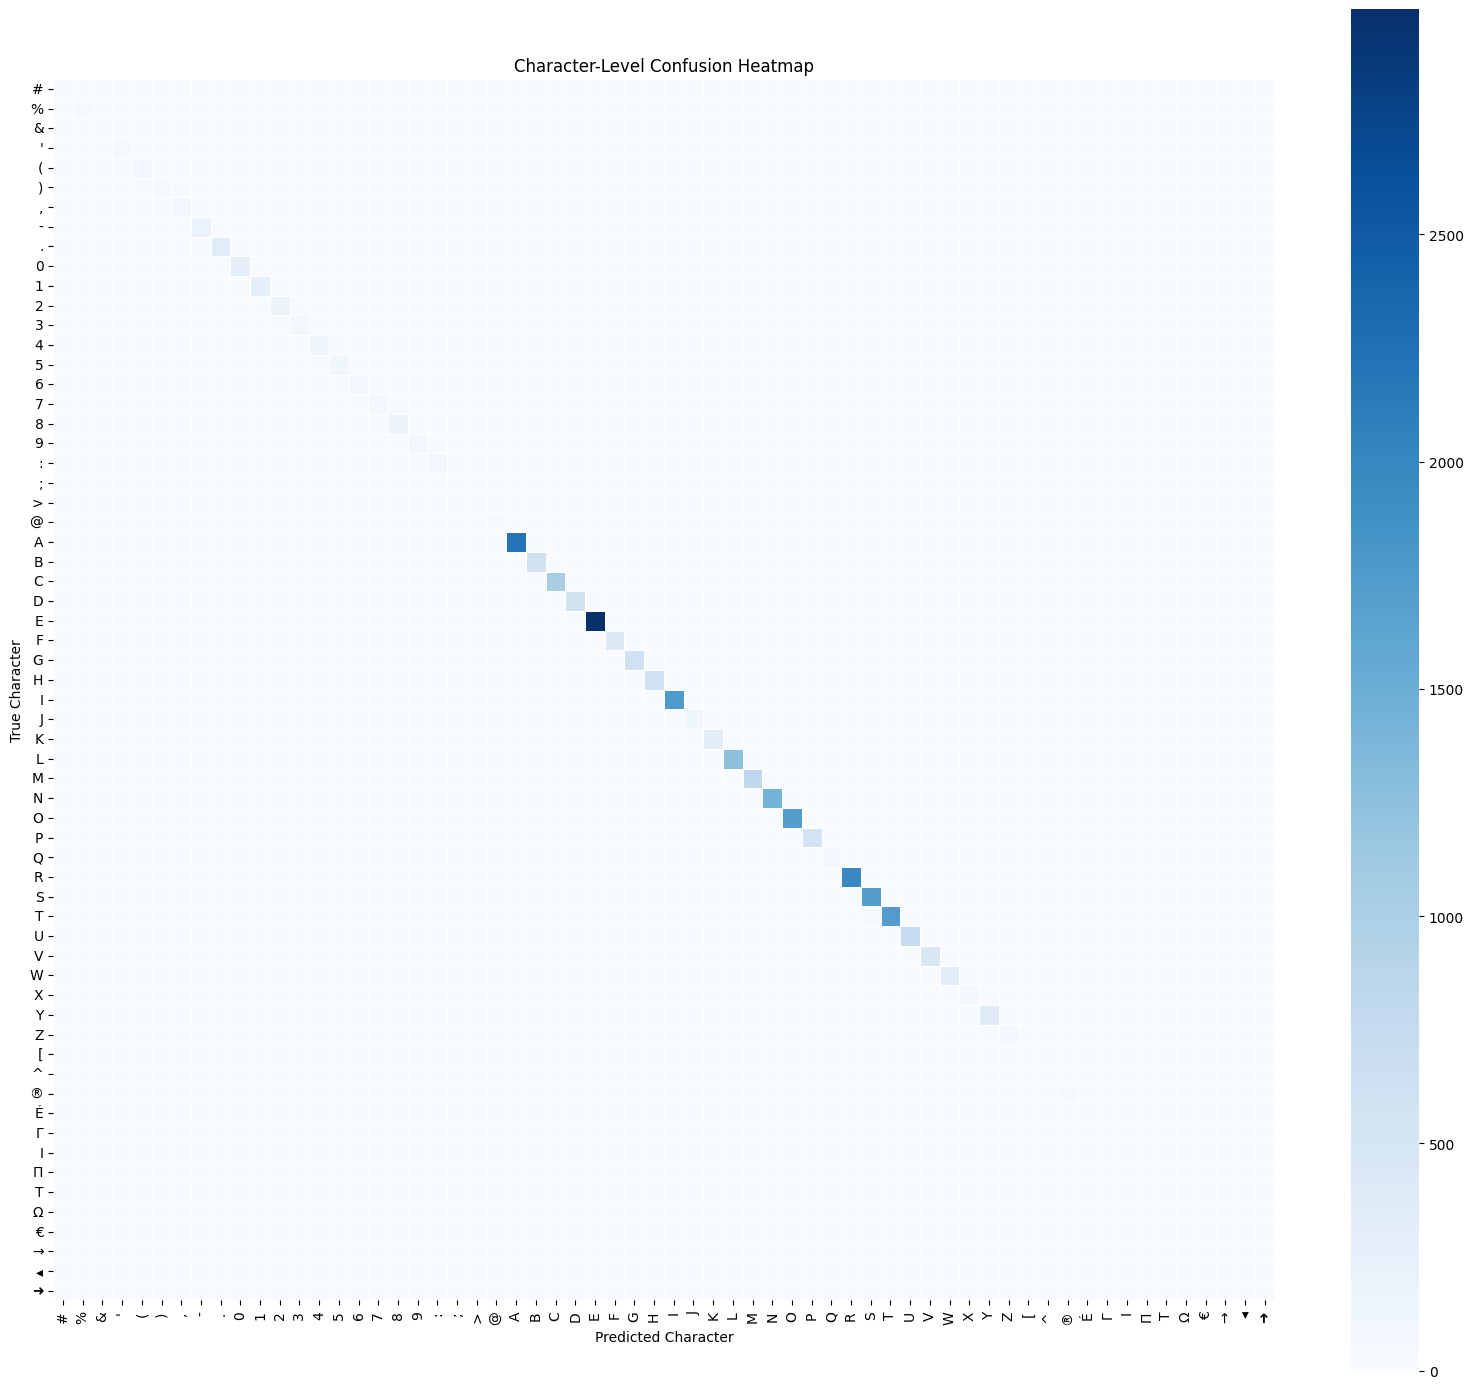

In [40]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(16, 14))
sns.heatmap(conf_matrix, xticklabels=char_labels, yticklabels=char_labels,
            cmap="Blues", linewidths=0.5, square=True)

plt.xlabel("Predicted Character")
plt.ylabel("True Character")
plt.title("Character-Level Confusion Heatmap")
plt.xticks(rotation=90)
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()


In [41]:
# Extract only the mismatched (false positive) pairs
false_positives = Counter()

for pred, truth in zip(char_preds, char_truth):
    for p, t in zip(pred, truth):
        if p != t:
            false_positives[(t, p)] += 1  # True → Predicted


In [42]:
print(" Most Frequent False Positive Pairs:")
for (true_char, pred_char), count in false_positives.most_common(15):
    print(f"True: '{true_char}' → Predicted: '{pred_char}' | {count} times")


 Most Frequent False Positive Pairs:
True: '1' → Predicted: 'S' | 18 times
True: 'T' → Predicted: 'S' | 16 times
True: 'I' → Predicted: 'T' | 11 times
True: 'S' → Predicted: 'Y' | 10 times
True: '0' → Predicted: '1' | 10 times
True: 'E' → Predicted: 'T' | 10 times
True: 'P' → Predicted: 'E' | 10 times
True: 'H' → Predicted: 'P' | 10 times
True: 'E' → Predicted: 'H' | 10 times
True: 'N' → Predicted: 'E' | 10 times
True: 'S' → Predicted: 'N' | 10 times
True: 'O' → Predicted: 'S' | 10 times
True: 'N' → Predicted: 'O' | 10 times
True: '2' → Predicted: '6' | 10 times
True: 'M' → Predicted: 'S' | 10 times


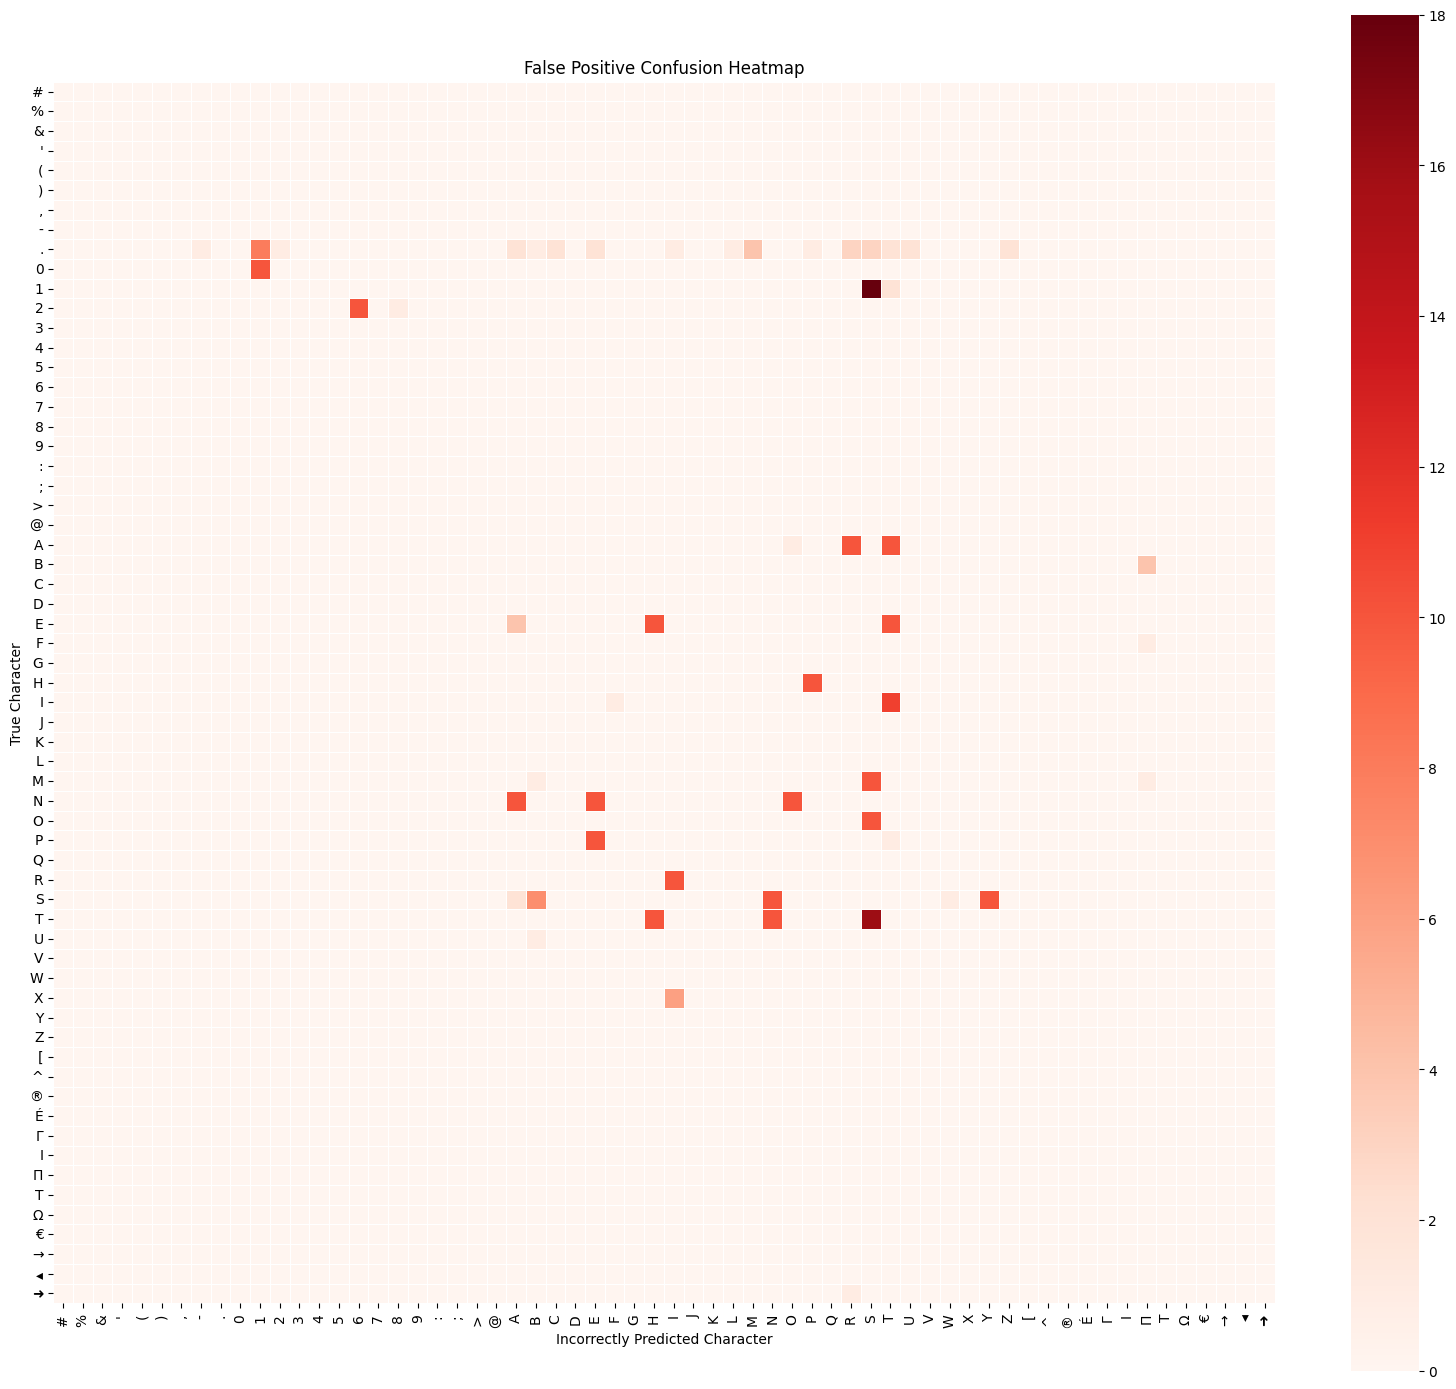

In [43]:
# Build matrix of false positive counts
fp_matrix = np.zeros((len(char_labels), len(char_labels)), dtype=int)

for (t, p), count in false_positives.items():
    if t in char_indices and p in char_indices:
        fp_matrix[char_indices[t], char_indices[p]] = count

# Plot heatmap
plt.figure(figsize=(16, 14))
sns.heatmap(fp_matrix, xticklabels=char_labels, yticklabels=char_labels,
            cmap="Reds", linewidths=0.5, square=True)

plt.xlabel("Incorrectly Predicted Character")
plt.ylabel("True Character")
plt.title("False Positive Confusion Heatmap")
plt.xticks(rotation=90)
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()
